# Landscape or Cityscape?

The idea behind this notebook is to test out various CNNs to determine which networks are best suited to determining if an picture is an image of a city or an image of nature. My data sources for this experiment are the subreddits r/earthporn and r/cityporn. I chose these subreddits as they are focused and fairly strictly moderated. Each contains only aestetically pleasing pictures of landscapes and cityscapes respectively. I took all the directly linked images from these subreddits since 1/1/17 that have over a certain threshold of upvotes, which gave me a few thousand images that are almost entirely either a picture of a natural landscape or a picture of a cityscape

I will use keras' implementations of VGG16 as feature extraction and experiment with a few different caps to find the best classifier for this problem

In [1]:
#general imports and commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
%matplotlib inline
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


In [2]:
#keras specific imports
from keras import Model, Input
from keras.layers import Dense, Flatten,GlobalMaxPool2D
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

from keras.applications import VGG16,vgg16

In [67]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000 

In [68]:
#functions for the project that I put in a .py to clean up the notebook
from importlib import reload
import project_utils
reload(project_utils)

<module 'project_utils' from '/home/ubuntu/Landscape_or_Cityscape/project_utils.py'>

In [69]:
#loading pretrained model weights
VGG = VGG16(weights = 'imagenet', include_top = False, input_shape= (224,224,3))

The first base model I will try is [VGG16](https://arxiv.org/abs/1409.1556). I will remove the top layers of the network, keeping only the convolutions as feature extraction, then max pool these features before feeding them into two fully connected layers and a softmax output layer

In [76]:
# This function takes in headless model (some pretrained CNN)
# and adds a max pooling and a dense fully connected layer to it.
def create_model1(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(100, activation = 'relu',name = '1')(X)
    predictions = Dense(2 , activation = 'softmax',name = '2')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

#same as the first function but there are two dense layers rather than just one 
def create_model2(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(200, activation = 'relu', name = '1')(X)
    X = Dense(100, activation = 'relu',name = '2')(X)
    predictions = Dense(2 , activation = 'softmax',name = '3')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model

#a model with one larger dense layer 
def create_model3(base_layers):
    for layer in base_layers.layers:
        layer.trainable = False
    X = base_layers.output
    X = GlobalMaxPool2D()(X)
    X = Dense(500, activation = 'relu',name = '2')(X)
    predictions = Dense(2 , activation = 'softmax',name = '3')(X)
    model = Model(inputs = base_layers.inputs, outputs = predictions)
    return model



In [80]:
#Preparing data generators
#this keras utilitiy will continously generate images that have been slightly rotated 
#or shifted or flipped from the directories where I stored the images for both training and validation
data_gen = ImageDataGenerator(shear_range= 0.2,
                                    zoom_range= 0.2,
                                    horizontal_flip= True,
                                    width_shift_range=0.2,
                                    height_shift_range = 0.2,
                                    preprocessing_function= (lambda x: x/127.5 - 1))                                           

train_generator = data_gen.flow_from_directory('./images/train', target_size= (224,224), class_mode= 'categorical')
validation_generator = data_gen.flow_from_directory('./images/validation', target_size= (224,224), class_mode= 'categorical')

max_pool_one_layer = [create_model1(VGG) for i in range(0,4)]

for model in max_pool_one_layer:
    model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

max_pool_two_layer = [create_model2(VGG) for i in range(0,4)]
for model in max_pool_two_layer:
    model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

max_pool_one_big = [create_model3(VGG) for i in range(0,4)]
for model in max_pool_one_big:
    model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy',metrics = ['accuracy'])

model_types = [max_pool_one_layer,max_pool_two_layer, max_pool_one_big]


Found 4850 images belonging to 2 classes.
Found 605 images belonging to 2 classes.


In [ ]:
#this will cause the model to stop fitting if the validation loss has gone down for 3 epochs
#this is to prevent overfitting by training the model for too long
early_stopping = EarlyStopping(min_delta = .01, 
                               patience = 3,
                               verbose = 1,
                               mode = 'min')

In [ ]:
i = 0
total = len([x for y in model_types for x in y])
for model_list in model_types:
    for model in model_list:
        model.fit_generator(generator = train_generator, 
                            epochs=20,
                            steps_per_epoch= 20, #there are 32 images per step so this is 64 per epoch
                            callbacks = [early_stopping],
                            validation_data = validation_generator,
                            validation_steps=10, 
                            workers=12,
                            use_multiprocessing=True,
                            verbose = 0) #validation on 320 images
        i+=1
        print("{}/{} models trained".format(i,total))    


Epoch 00007: early stopping
1/12 models trained
Epoch 00006: early stopping
2/12 models trained


In [ ]:
#makes and evalutes the model on the test set
X_test, y_test = project_utils.get_test()

In [ ]:
#Evaluate 1 layer top
for model in max_pool_one_layer:
    rocs = []
    rocs.append(project_utils.evaluate_and_confusion_matrix(X_test,y_test, model, print_res=True))
    print("Mean ROCAUC score: {}".format())

In [ ]:
#Evaluate 2 layer top
for model in max_pool_two_layer:
    rocs = []
    rocs.append(project_utils.evaluate_and_confusion_matrix(X_test,y_test, model, print_res=True))
    print("Mean ROCAUC score: {}".format())

In [ ]:
#evaluate model with large top layer 
for model in max_pool_one_big:
    rocs = []
    rocs.append(project_utils.evaluate_and_confusion_matrix(X_test,y_test, model, print_res=True))
    print("Mean ROCAUC score: {}".format())

In [ ]:
#function to help with error analysis and sanity checking
def show_and_predict(path,model1,model2,modelname):
    pylab.imshow(pylab.imread(path))
    prepped = project_utils.prep_for_model(path,modelname)
    pred = model1.predict(prepped)
    pred2 = model2.predict(prepped)
    print("Model1:")
    print("p(city): {}, p(nature): {}".format(pred[0,0],pred[0,1]))
    print("Model2")
    print("p(city): {}, p(nature): {}".format(pred2[0,0],pred2[0,1]))

    

Model1:
p(city): 0.9995197057723999, p(nature): 0.00048024594434536994
Model2
p(city): 0.9998656511306763, p(nature): 0.0001343809417448938


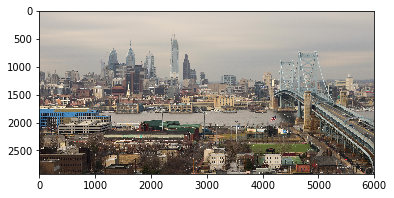

In [14]:
show_and_predict('images/test/cityporn_3_10/image229.jpg',vgg_model1,vgg_model2,'vgg16')

Model1:
p(city): 0.0022741053253412247, p(nature): 0.9977259039878845
Model2
p(city): 0.0012309823650866747, p(nature): 0.9987689852714539


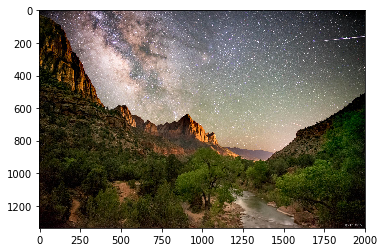

In [15]:
show_and_predict('images/test/earthporn_3_10/image3077.jpg',vgg_model1,vgg_model2,'vgg16')

Model1:
p(city): 0.9820636510848999, p(nature): 0.01793631725013256
Model2
p(city): 0.9904370903968811, p(nature): 0.009562921710312366


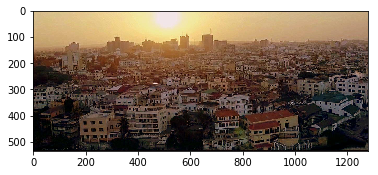

In [16]:
show_and_predict('images/test/cityporn_3_10/image971.jpg',vgg_model1,vgg_model2,'vgg16')

This network is doing pretty well! Its at about 95% accuracy between the classes and the loss is fairly low. Still, it is worth it to try out some other base layers to see if we can do even better. The next base network that I will try out is [Inception V3](https://arxiv.org/abs/1512.00567)

In [25]:
-